# Data Augmentation EP2.1

Os notebooks também estão no repositório MAC5768 no [Github](https://github.com/iblucher/MAC5768), e os datasets estão na pasta `ep2` no [Google Drive](https://drive.google.com/drive/folders/1DtkTzyPvNXYur2LldKeOHN6mOhBy2t_-?usp=sharing).

In [1]:
import os
from pathlib import Path 

from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

from scipy import signal

from skimage import io, img_as_ubyte
from skimage.color import rgb2gray

%matplotlib inline

## Criação do originalGrayDataset

Usando a funcão `rgb2gray` do `skimage`

In [2]:
ORIGINAL_DATASET_PATH = Path('output_data')
ORIGINAL_GRAY_DATASET_PATH = Path('original_gray_dataset')

for filename in ORIGINAL_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        path = f'{ORIGINAL_GRAY_DATASET_PATH}/{object_class}'
        if not os.path.exists(path):
            os.makedirs(path)
        
        img = io.imread(filename)
        gray_img = rgb2gray(img)
        uint8_gray_img = img_as_ubyte(gray_img)
        io.imsave(f'{path}/{tail}', uint8_gray_img)

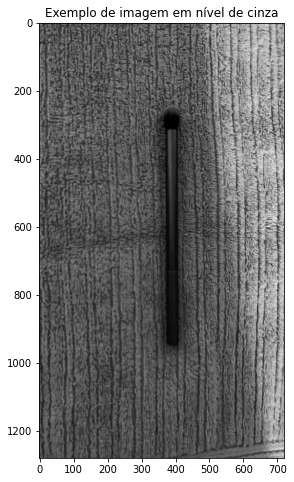

In [55]:
gray_fig = plt.figure(figsize=(12, 8))
gray_ax = gray_fig.add_subplot(111)

gray_ax.imshow(gray_img, cmap='gray')
gray_ax.set_title('Exemplo de imagem em nível de cinza');

## Data Augmentation

### Soma de fundo com gradiente de níveis de cinza

In [3]:
def create_circular_gradient(h, w):
    center = (int(w/2), int(h/2))
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    dist_from_center *= (255 / dist_from_center.max())
    uint8_dist_from_center = dist_from_center.astype(np.uint8)

    return uint8_dist_from_center

In [4]:
def sum_gradient_mask(img, gradient_mask):
    h, w = img.shape
    sum_of_gradient = img / 1 + gradient_mask / 1
    uint8_sum_of_gradient = np.where(sum_of_gradient > 255, 255, sum_of_gradient).astype(np.uint8)
    
    return uint8_sum_of_gradient

In [5]:
ORIGINAL_GRAY_DATASET_PATH = Path('original_gray_dataset')
GRADIENT_SUM_PATH = Path('gradient_sum')

GRADIENT_MASK = create_circular_gradient(1280, 720)  # constant because it's the same for all images

for filename in ORIGINAL_GRAY_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        gradient_path = f'{GRADIENT_SUM_PATH}/{object_class}'
        if not os.path.exists(gradient_path):
            os.makedirs(gradient_path)
        
        img = io.imread(filename)
        sum_of_gradient_img = sum_gradient_mask(img, GRADIENT_MASK)
        io.imsave(f'{gradient_path}/sum_gradient_{tail}', sum_of_gradient_img)

Text(0.5, 1.0, 'Gradiente usado para somar com as imagens do originalGrayDataset')

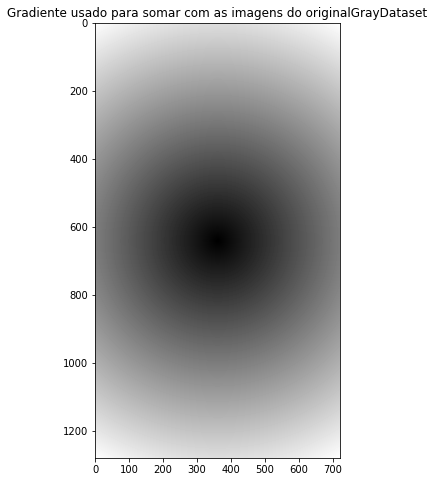

In [6]:
mask_fig = plt.figure(figsize=(12, 8))
ax = mask_fig.add_subplot(111)

ax.imshow(GRADIENT_MASK, cmap='gray')
ax.set_title('Gradiente usado para somar com as imagens do originalGrayDataset');

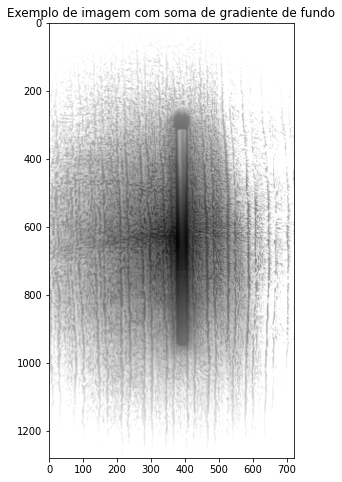

In [47]:
sum_of_gradient_fig = plt.figure(figsize=(12, 8))
sum_of_gradient_ax = sum_of_gradient_fig.add_subplot(111)

sum_of_gradient_ax.imshow(sum_of_gradient_img, cmap='gray')
sum_of_gradient_ax.set_title('Exemplo de imagem com soma de gradiente de fundo');

### Logaritmo da imagem

In [7]:
# assuming the max pixel value will always be 255
MAX_PIXEL_VALUE = 255
c = 255 / (np.log (1 + MAX_PIXEL_VALUE))

def log_transform(img, c=c):
    log_of_image = c * np.log(img / 1 + 1)
    round_log_of_image = np.minimum(log_of_image, 255).astype(np.uint8)
    
    return round_log_of_image

In [8]:
ORIGINAL_GRAY_DATASET_PATH = Path('original_gray_dataset')
LOG_PATH = Path('log')

for filename in ORIGINAL_GRAY_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        log_path = f'{LOG_PATH}/{object_class}'
        if not os.path.exists(log_path):
            os.makedirs(log_path)
        
        img = io.imread(filename)
        log_img = log_transform(img)
        io.imsave(f'{log_path}/log_{tail}', log_img)

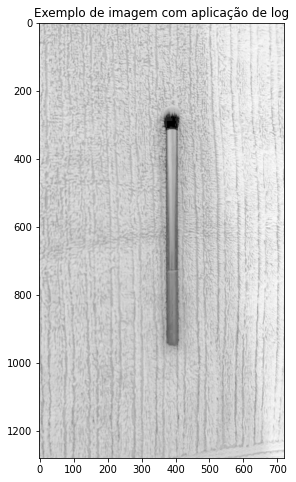

In [48]:
log_fig = plt.figure(figsize=(12, 8))
log_ax = log_fig.add_subplot(111)

log_ax.imshow(log_img, cmap='gray')
log_ax.set_title('Exemplo de imagem com aplicação de log');

### Função potência (gamma)

In [9]:
def gamma_correction(img, gamma=2.5):
    c = 255**(1 - gamma)
    gamma_corrected_img = c * (img / 1)**gamma
    uint8_gamma_corrected = np.minimum(gamma_corrected_img, 255).astype(np.uint8)
    
    return uint8_gamma_corrected

In [10]:
ORIGINAL_GRAY_DATASET_PATH = Path('original_gray_dataset')
GAMMA_PATH = Path('gamma')

for filename in ORIGINAL_GRAY_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        gamma_path = f'{GAMMA_PATH}/{object_class}'
        if not os.path.exists(gamma_path):
            os.makedirs(gamma_path)
        
        img = io.imread(filename)
        gamma_corrected_img = gamma_correction(img)
        io.imsave(f'{gamma_path}/gamma_{tail}', gamma_corrected_img)

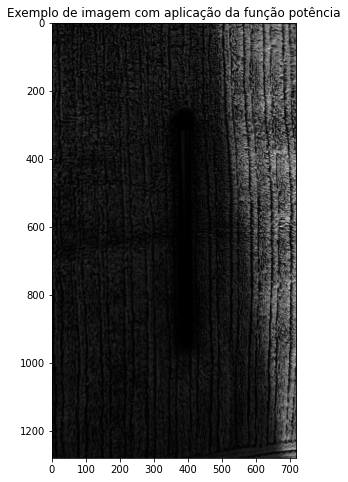

In [50]:
gamma_fig = plt.figure(figsize=(12, 8))
gamma_ax = gamma_fig.add_subplot(111)

gamma_ax.imshow(gamma_corrected_img, cmap='gray')
gamma_ax.set_title('Exemplo de imagem com aplicação da função potência');

### Filtro da média usando convolução

In [11]:
def mean_filter(img, kernel_size=8):
    kernel = np.full((kernel_size, kernel_size), 1 / kernel_size**2)
    convolved_img = signal.convolve2d(img / 1, kernel, mode='same')
    uint8_mean_filter = np.minimum(convolved_img, 255).astype(np.uint8)
    
    return uint8_mean_filter

In [12]:
ORIGINAL_GRAY_DATASET_PATH = Path('original_gray_dataset')
MEAN_FILTER_PATH = Path('mean_filter')

for filename in ORIGINAL_GRAY_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        mean_filter_path = f'{MEAN_FILTER_PATH}/{object_class}'
        if not os.path.exists(mean_filter_path):
            os.makedirs(mean_filter_path)
        
        img = io.imread(filename)
        mean_filter_img = mean_filter(img)
        io.imsave(f'{mean_filter_path}/mean_filter_{tail}', mean_filter_img)

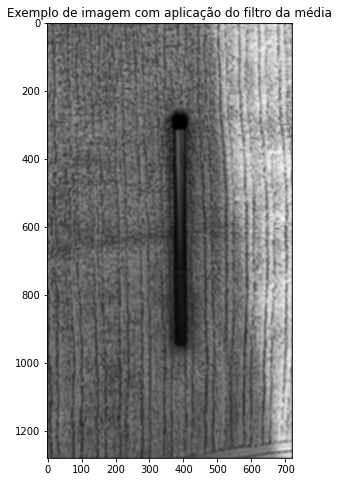

In [51]:
mean_filter_fig = plt.figure(figsize=(12, 8))
mean_filter_ax = mean_filter_fig.add_subplot(111)

mean_filter_ax.imshow(mean_filter_img, cmap='gray')
mean_filter_ax.set_title('Exemplo de imagem com aplicação do filtro da média');

## Montando o augmentedDataset

In [38]:
AUGMENTED_FOLDERS = ['original_gray_dataset', 'gradient_sum', 'log', 'gamma', 'mean_filter']

AUGMENTED_DATASET_PATH = Path('augmented_dataset')

for folder in AUGMENTED_FOLDERS:
    for filename in Path(folder).rglob('*'):
        if filename.is_file():
            head, tail = os.path.split(filename)
            object_class = head.split('/')[-1]
            augmented_path = f'{AUGMENTED_DATASET_PATH}/{object_class}'
            if not os.path.exists(augmented_path):
                os.makedirs(augmented_path)
            
            img = io.imread(filename)
            io.imsave(f'{augmented_path}/{tail}', img)

In [39]:
original_gray_dataset_images = [name for name in Path(ORIGINAL_GRAY_DATASET_PATH).rglob('*') if name.is_file()]
len(original_gray_dataset_images)

1296

In [40]:
augmented_dataset_images = [name for name in Path(AUGMENTED_DATASET_PATH).rglob('*') if name.is_file()]
len(augmented_dataset_images)

6480

In [41]:
np.random.seed(0)

sample = np.random.choice(augmented_dataset_images, 30)

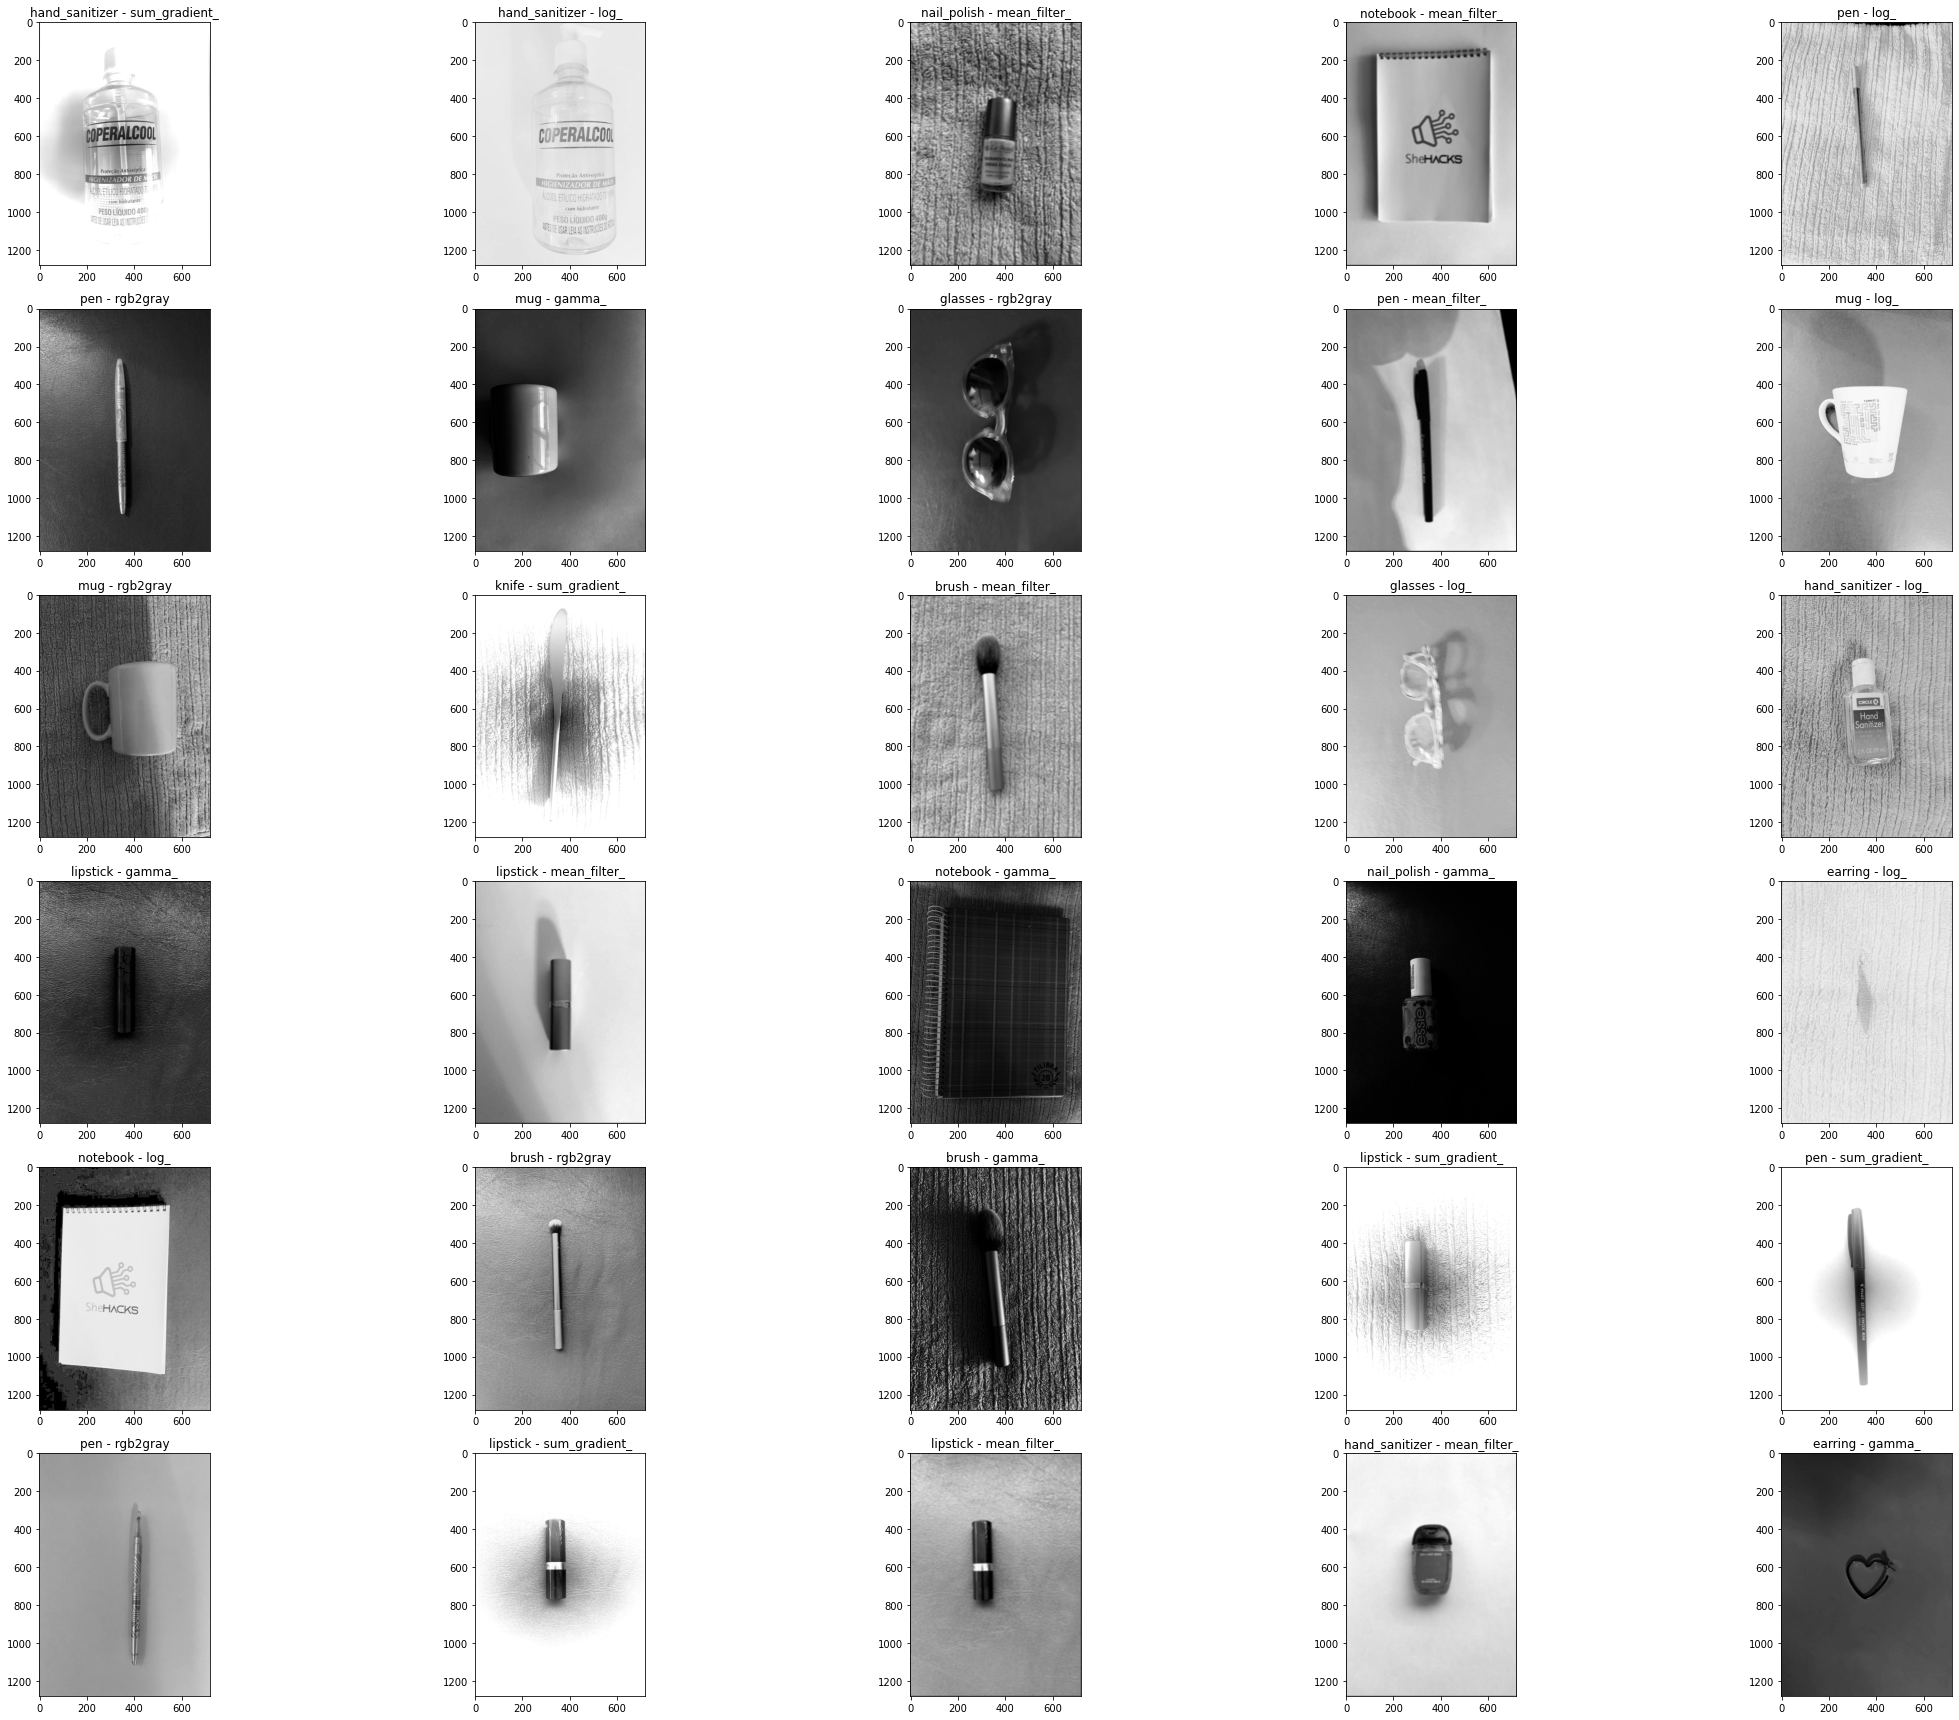

In [54]:
fig, axes = plt.subplots(6, 5, figsize=(32, 24))
axs = axes.ravel()

for i, file in enumerate(sample):
    head, tail = os.path.split(file)
    object_class = head.split('/')[-1]
    transform_type = tail.split('IMG')[0] if tail.split('IMG')[0] else 'rgb2gray'
    
    img = io.imread(file)
    axs[i].imshow(img, cmap='gray')
    axs[i].set_aspect(0.8)
    axs[i].set_title(f'{object_class} - {transform_type}')
    
fig.tight_layout()